In [13]:
import torch
import torchvision.models as models
import warnings
import matplotlib.pyplot as plt
from PIL import Image

warnings.filterwarnings("ignore")

# Q1

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = models.vgg16(pretrained=True).to(device)
# model = models.resnet50(pretrained=True).to(device)
# model = models.efficientnet_b0(pretrained=True).to(device)

cuda


# Q2

In [3]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
from torchinfo import summary
print(summary(model))

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

# Q3

In [5]:
import torchvision.transforms as T
from torchvision.io import read_image
# pre-traitements sur les images d’entree
preprocess = T.Compose([T.ConvertImageDtype(torch.float32), # passe dans [0 ;1]
T.Resize(256),
T.CenterCrop(224), # VGG traite des images 224x224 px
# standardisation tq moy=0 et etype=1, sur stats ImageNet
# aide le reseau a garder des poids autour de 0
T.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
])
# read_image donne directement un Tensor sans image PIL intermediaire
cougar = read_image('test/cougar.jpg').to(device)
print(cougar.shape) # 3xHxW
print(cougar.dtype)
img = preprocess(cougar)
print(img.shape)
print(img.dtype)

torch.Size([3, 288, 300])
torch.uint8
torch.Size([3, 224, 224])
torch.float32


# Q4

In [6]:
from torch import nn
model.eval() # comportement pour eval/inference
input_batch = img[None,] # ajout dimension Batch en 1er ; <=> unsqueeze()
with torch.no_grad(): # ou with torch.inference_mode() :
    y = model(input_batch)
    y = nn.functional.softmax(y, dim=1) # softmax apres la derniere couche
    y = y[0] # reprendre la seule image traitee dans cet exemple
print(y.shape)
print(y.sum())

torch.Size([1000])
tensor(1.0000, device='cuda:0')


# Q5

In [7]:
# lire la liste des classes ImageNet
with open("imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

# decoder la classe de l’image
def predictions(y, topn = 5):
    res = "Predictions et probas :\n"
    top_prob, top_cid = torch.topk(y, topn)
    for i in range(top_prob.size(0)):
        res += "{:20}\t{:.6f}\n".format(classes[top_cid[i]], top_prob[i])
    return res

# Q6

In [8]:
import os

for image in os.listdir('test'):
    img = read_image('test/' + image).to(device)
    image_name = image.split('.')[0]
    img = preprocess(img)
    input_batch = img[None,]
    with torch.no_grad():
        y = model(input_batch)
        y = nn.functional.softmax(y, dim=1)
        y = y[0]
    print("Image: " + image_name)
    print(predictions(y))
    print("\n")

Image: kangaroo
Predictions et probas :
dingo               	0.437295
dhole               	0.137195
coyote              	0.057230
red wolf            	0.041477
Egyptian cat        	0.036628



Image: crab
Predictions et probas :
fiddler crab        	0.741646
tick                	0.128181
rock crab           	0.107347
king crab           	0.009550
barn spider         	0.004978



Image: cougar
Predictions et probas :
cougar              	0.950635
lion                	0.046562
lynx                	0.002350
ice bear            	0.000151
brown bear          	0.000114





# Q7

In [9]:
from torchvision.models.feature_extraction import create_feature_extractor
# dictionnaire des couches desirees avec nommage a la carte, ici juste 1
return_nodes = {"classifier.3": "features"} # couche dense avant ReLU
# return_nodes = {"flatten": "features"} # changer pour cette ligne si ResNet ou EfficientNet
model_feat = create_feature_extractor(model, return_nodes=return_nodes)
model_feat.eval()

VGG(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

# Q8

In [10]:
from scipy.spatial import distance

image_dir = 'images/'

# Extraction des caractéristiques
features_dict = {}

for image_file in os.listdir(image_dir):
    img_path = os.path.join(image_dir, image_file)
    img = read_image(img_path).to(device)
    img = preprocess(img)
    input_batch = img[None,]
    
    with torch.no_grad():
        features = model_feat(input_batch)['features'].cpu().numpy().flatten()
    
    features_dict[image_file] = features

# np.save('image_features.npy', features_dict)
# features_dict = np.load('image_features.npy', allow_pickle=True).item()


kangaroo.jpg:


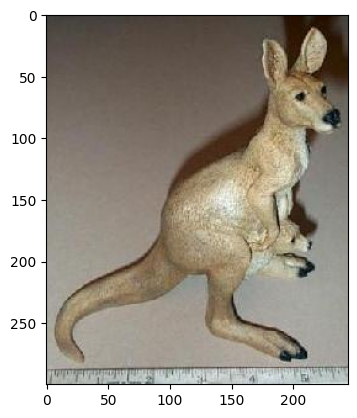

Images les plus proches:


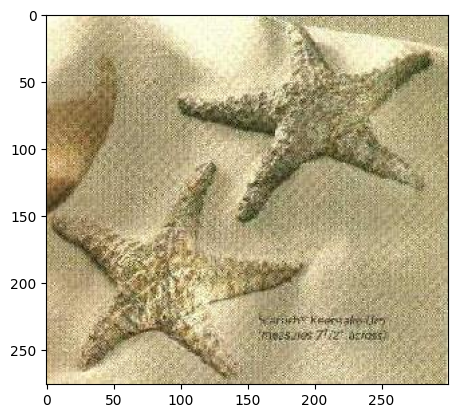

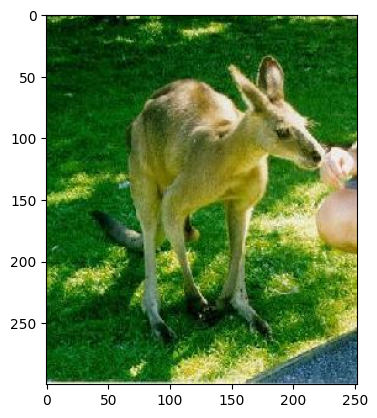

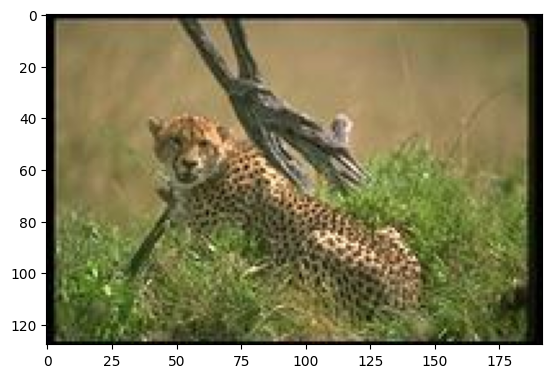





crab.jpg:


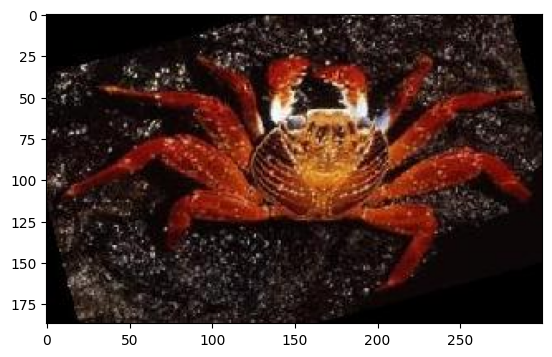

Images les plus proches:


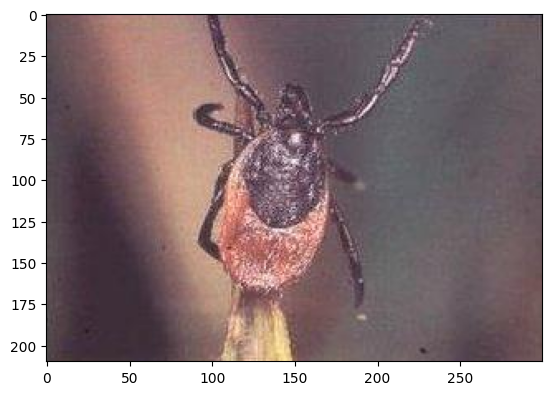

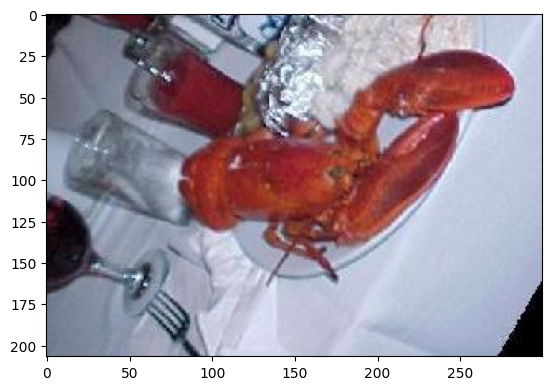

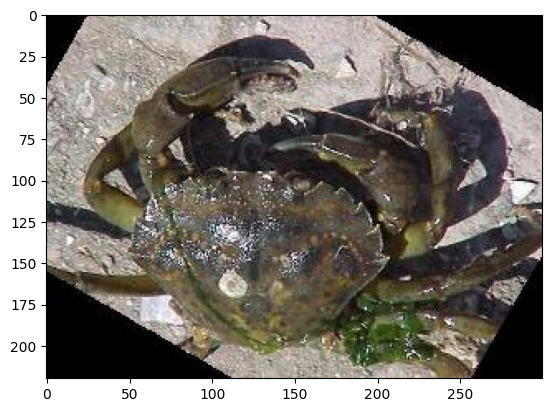





cougar.jpg:


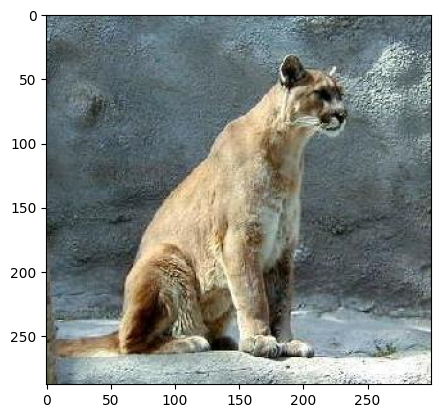

Images les plus proches:


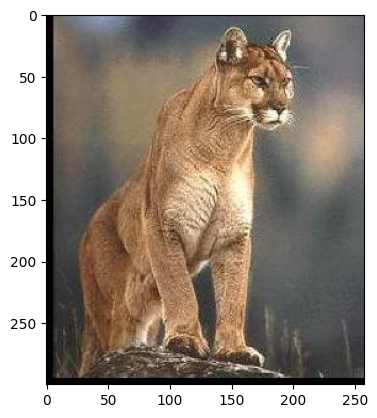

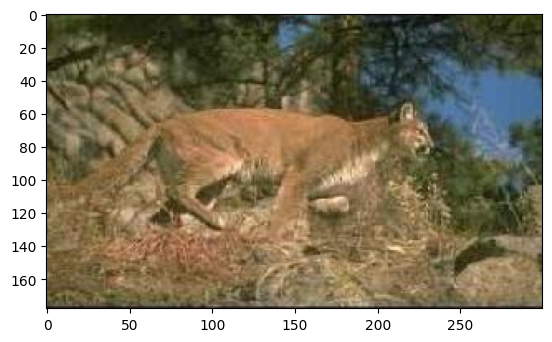

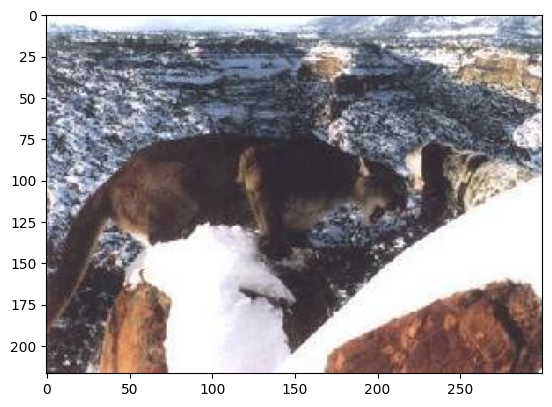

In [15]:
# Fonction pour trouver les images les plus proches
def find_closest_images(test_img_path, features_dict, top_n=3):
    img = read_image(test_img_path).to(device)
    img = preprocess(img)
    input_batch = img[None,]
    
    with torch.no_grad():
        test_features = model_feat(input_batch)['features'].cpu().numpy().flatten()
    
    # Calcul des distances euclidiennes
    distances = {img_name: distance.euclidean(test_features, features) for img_name, features in features_dict.items()}
    
    # Tri par distance
    closest_images = sorted(distances, key=distances.get)[:top_n]
    
    return closest_images

for image in os.listdir('test'):
    test_img_path = os.path.join('test', image)
    closest_images = find_closest_images(test_img_path, features_dict)
    
    print(f"{image}:")
    plt.figure()
    plt.imshow(Image.open(test_img_path))
    plt.show()
    print("Images les plus proches:")
    for img in closest_images:
        plt.figure()
        plt.imshow(Image.open(os.path.join(image_dir, img)))
        plt.show()
    print("\n\n\n")


# Q9
Décommenter la ligne correspondant pour la cellule Q1, et séléctionner la bonne ligne Q7 pour ResNet ou EfficientNet.